# Precipitation nowcast

It is based on https://github.com/pySTEPS/pysteps/blob/master/examples/my_first_nowcast.ipynb

In this example, we will use pysteps to compute and plot an extrapolation nowcast using the NSSL's Multi-Radar/Multi-Sensor System
([MRMS](https://www.nssl.noaa.gov/projects/mrms/)) rain rate product.

The MRMS precipitation product is available every 2 minutes, over the contiguous US. 
Each precipitation composite has 3500 x 7000 grid points, separated 1 km from each other.

## Init

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = 'retina' # High-resolution plot outputs for Retina laptops

In [2]:
# Batteries
import time
from pathlib import Path


# Externals
import numpy as np
from matplotlib import pyplot as plt
from pprint import pprint


# Pysteps
import pysteps
from pysteps import motion # calc motion field
from pysteps import nowcasts # predict
from pysteps import verification


# Pysteps tools
from pysteps.datasets import load_dataset
from pysteps.utils import transformation
from pysteps.visualization import plot_precip_field, quiver

Pysteps configuration file found at: /Users/ilirium/.pysteps/pystepsrc



## Load the MRMS example data

Now that we have installed the example data, let's import the example MRMS dataset using the [load_dataset()](https://pysteps.readthedocs.io/en/latest/generated/pysteps.datasets.load_dataset.html) helper function from the `pysteps.datasets` module.

We import 1 hour and 10 minutes of data, which corresponds to a sequence of 35 frames of 2-D precipitation composites.
Note that importing the data takes approximately 30 seconds.

In [3]:
start_time = time.monotonic()

# Import the data
precipitation, metadata, timestep = load_dataset('mrms',frames=35)  # precipitation in mm/h

end_time = time.monotonic()

print("Precipitation data imported")
print("Importing the data took ", (end_time - start_time), " seconds")

Precipitation data imported
Importing the data took  53.366884364  seconds


Let's have a look at the values returned by the `load_dataset()` function. 

- `precipitation`: A numpy array with (time, latitude, longitude) dimensions.
- `metadata`: A dictionary with additional information (pixel sizes, map projections, etc.).
- `timestep`: Time separation between each sample (in minutes)

In [4]:
# Let's inspect the shape of the imported data array
precipitation.shape

(35, 875, 1750)

Note that the shape of the precipitation is 4 times smaller than the raw MRMS data (3500 x 7000).
The `load_dataset()` function uses the default parameters from `importers` to read the data. By default, the MRMS importer upscales the data 4x. That is, from ~1km resolution to ~4km. It also uses single precision to reduce the memory requirements.
Thanks to the upscaling, the memory footprint of this example dataset is ~200Mb instead of the 3.1Gb of the raw (3500 x 7000) data. 

# Functions

## `show_array_structure`

In [5]:
def show_array_structure(array):
    print(f'shape = {array.shape}')
    
    size = array.shape[0] * array.shape[1] * array.shape[2]
    print(f'shape[0] * shape[1] * shape[2] = {size}')
    
    nan_amount = array[np.isnan(array)].shape[0]
    nan_percent = round(nan_amount / size, 3)
    print(f'NAN amount = {nan_amount}, part = {nan_percent}')
    
    finite_amount = array[~np.isnan(array)].shape[0]
    finite_percent = round(finite_amount / size, 3)
    print(f'FINITE amount = {finite_amount}, part = {finite_percent}')
    print()
    print(f'unique = {np.sort(np.unique(array[np.isfinite(array)]))}')

# Compute nowcast

So far, we have 1 hour and 10 minutes of precipitation images, separated 2 minutes from each other.
But, how do we use that data to run a precipitation forecast? 

A simple way is by extrapolating the precipitation field, assuming it will continue to move as observed in the recent past, and without changes in intensity. This is commonly known as *Lagrangian persistence*.

The first step to run our nowcast based on Lagrangian persistence, is the estimation of the motion field from a sequence of past precipitation observations.
We use the Lucas-Kanade (LK) optical flow method implemented in pysteps.
This method follows a local tracking approach that relies on the OpenCV package.
Local features are tracked in a sequence of two or more radar images.
The scheme includes a final interpolation step to produce a smooth field of motion vectors.
Other optical flow methods are also available in pysteps. 
Check the full list [here](https://pysteps.readthedocs.io/en/latest/pysteps_reference/motion.html).

Now let's use the first 5 precipitation images (10 min) to estimate the motion field of the radar pattern and the remaining 30 images (1h) to evaluate the quality of our forecast.

## Train and valid

In [6]:
# precipitation[0:5] -> Used to find motion (past data). Let's call it training precip.
train_precip = precipitation[0:5]

# precipitation[5:] -> Used to evaluate forecasts (future data, not available in "real" forecast situation)
# Let's call it observed precipitation because we will use it to compare our forecast with the actual observations.
observed_precip = precipitation[5:]

In [7]:
train_precip.shape, observed_precip.shape

((5, 875, 1750), (30, 875, 1750))

## R to dBR 

The histogram shows that rain rate values have a non-Gaussian and asymmetric distribution that is bounded at zero. Also, the probability of occurrence decays extremely fast with increasing rain rate values (note the logarithmic y-axis).


For better performance of the motion estimation algorithms, we can convert the rain rate values (in mm/h) to a more log-normal distribution  of rain rates by applying the following logarithmic transformation:

\begin{equation}
R\rightarrow
\begin{cases}
    10\log_{10}R, & \text{if } R\geq 0.1\text{mm h$^{-1}$} \\
    -15,          & \text{otherwise}
\end{cases}
\end{equation}

The transformed precipitation corresponds to logarithmic rain rates in units of dBR. The value of −15 dBR is equivalent to assigning a rain rate of approximately 0.03 mm h$^{−1}$ to the zeros. 

In [8]:
# Log-transform the data to dBR. 
# The threshold of 0.1 mm/h sets the fill value to -15 dBR.
train_precip_dbr, metadata_dbr = transformation.dB_transform(train_precip, metadata, 
                                                             threshold=0.1, 
                                                             zerovalue=-15.0)

## Motion field: `Lucas-Kanade`

Now we can estimate the motion field. Here we use a local feature-tracking approach (Lucas-Kanade).
However, check the other methods available in the [pysteps.motion](https://pysteps.readthedocs.io/en/latest/pysteps_reference/motion.html) module.

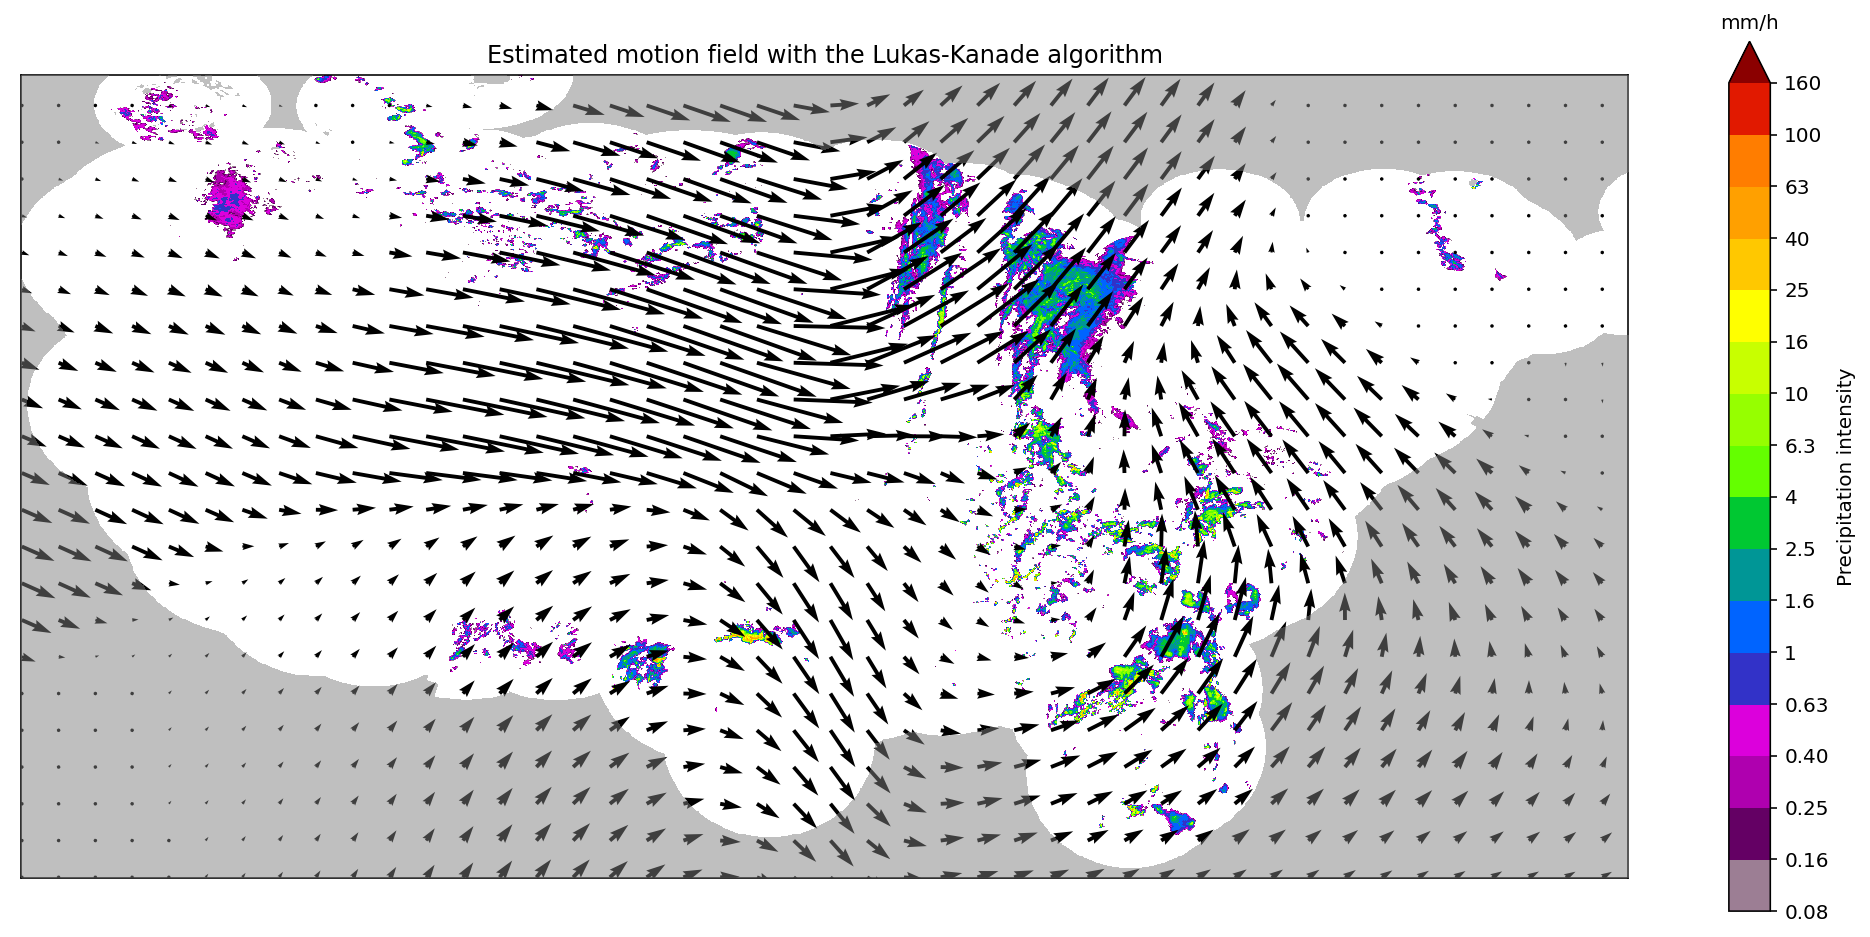

In [9]:
# Import the Lucas-Kanade optical flow algorithm
oflow_method = motion.get_method("LK")

# Estimate the motion field from the training data (in dBR)
motion_field = oflow_method(train_precip_dbr)

## Plot the motion field.
# Use a figure size that looks nice ;)
plt.figure(figsize=(18, 10))
plt.title("Estimated motion field with the Lukas-Kanade algorithm")

# Plot the last rainfall field in the "training" data.
# Remember to use the mm/h precipitation data since plot_precip_field assumes 
# mm/h by default. You can change this behavior using the "units" keyword.
plot_precip_field(train_precip[-1], geodata=metadata, axis="off")

# Plot the motion field vectors
quiver(motion_field, geodata=metadata, step=40)

plt.show()

## Predict: `S-PROG`

### Required arguments

In [10]:
R_thr = -10.0  # mm/h

### Optional arguments

In [11]:
fft_method = 'pyfftw'

### Calculate

We have all ingredients to make an extrapolation nowcast now. 
The final step is to advect the most recent radar rainfall field along the estimated motion field, producing an extrapolation forecast.

In [12]:
start = time.monotonic()

# Extrapolate the last radar observation
extrapolate = nowcasts.get_method("sprog")


# You can use the precipitation observations directly in mm/h for this step.
train_precip_3xslices = train_precip_dbr[2:]
train_precip_3xslices[~np.isfinite(train_precip_3xslices)] = metadata_dbr["zerovalue"]


# We set the number of leadtimes (the length of the forecast horizon) to the 
# length of the observed/verification preipitation data. In this way, we'll get
# a forecast that covers these time intervals.
n_leadtimes = observed_precip.shape[0]


# Advect the most recent radar rainfall field and make the nowcast.
precip_forecast = extrapolate(
    # required
    R = train_precip_3xslices,
    V = motion_field,
    n_timesteps = n_leadtimes,
    R_thr = R_thr,
    
    # optional
    fft_method = fft_method
)


# This shows the shape of the resulting array with [time intervals, rows, cols]
print("The shape of the resulting array is: ", precip_forecast.shape)

end = time.monotonic()
print("Advecting the radar rainfall fields took ", (end - start), " seconds")

Computing S-PROG nowcast:
-------------------------

Inputs:
-------
input dimensions: 875x1750

Methods:
--------
extrapolation:          semilagrangian
bandpass filter:        gaussian
decomposition:          fft
conditional statistics: no
probability matching:   mean
FFT method:             pyfftw
domain:                 spatial

Parameters:
-----------
number of time steps:     30
parallel threads:         1
number of cascade levels: 6
order of the AR(p) model: 2
precip. intensity threshold: -10
************************************************
* Correlation coefficients for cascade levels: *
************************************************
-----------------------------------------
| Level |     Lag-1     |     Lag-2     |
-----------------------------------------
| 1     | 0.999984      | 0.999918      |
-----------------------------------------
| 2     | 0.999921      | 0.999579      |
-----------------------------------------
| 3     | 0.999464      | 0.996634      |
------------

## dBR to R

In [18]:
precip_forecast_r = transformation.dB_transform(precip_forecast, threshold=-10.0, inverse=True)[0]

In [20]:
show_array_structure(precip_forecast)

shape = (30, 875, 1750)
shape[0] * shape[1] * shape[2] = 45937500
NAN amount = 139781, part = 0.003
FINITE amount = 45797719, part = 0.997

unique = [-15.         -12.34177366 -12.33945256 ...  29.28367316  29.70645152
  29.82644705]


In [19]:
show_array_structure(precip_forecast_r)

shape = (30, 875, 1750)
shape[0] * shape[1] * shape[2] = 45937500
NAN amount = 139781, part = 0.003
FINITE amount = 45797719, part = 0.997

unique = [0.00000000e+00 1.00003999e-01 1.00006246e-01 ... 8.47944282e+02
 9.34641696e+02 9.60825907e+02]


## Plot prediction

Let's inspect the last forecast time (hence this is the forecast rainfall an hour ahead).

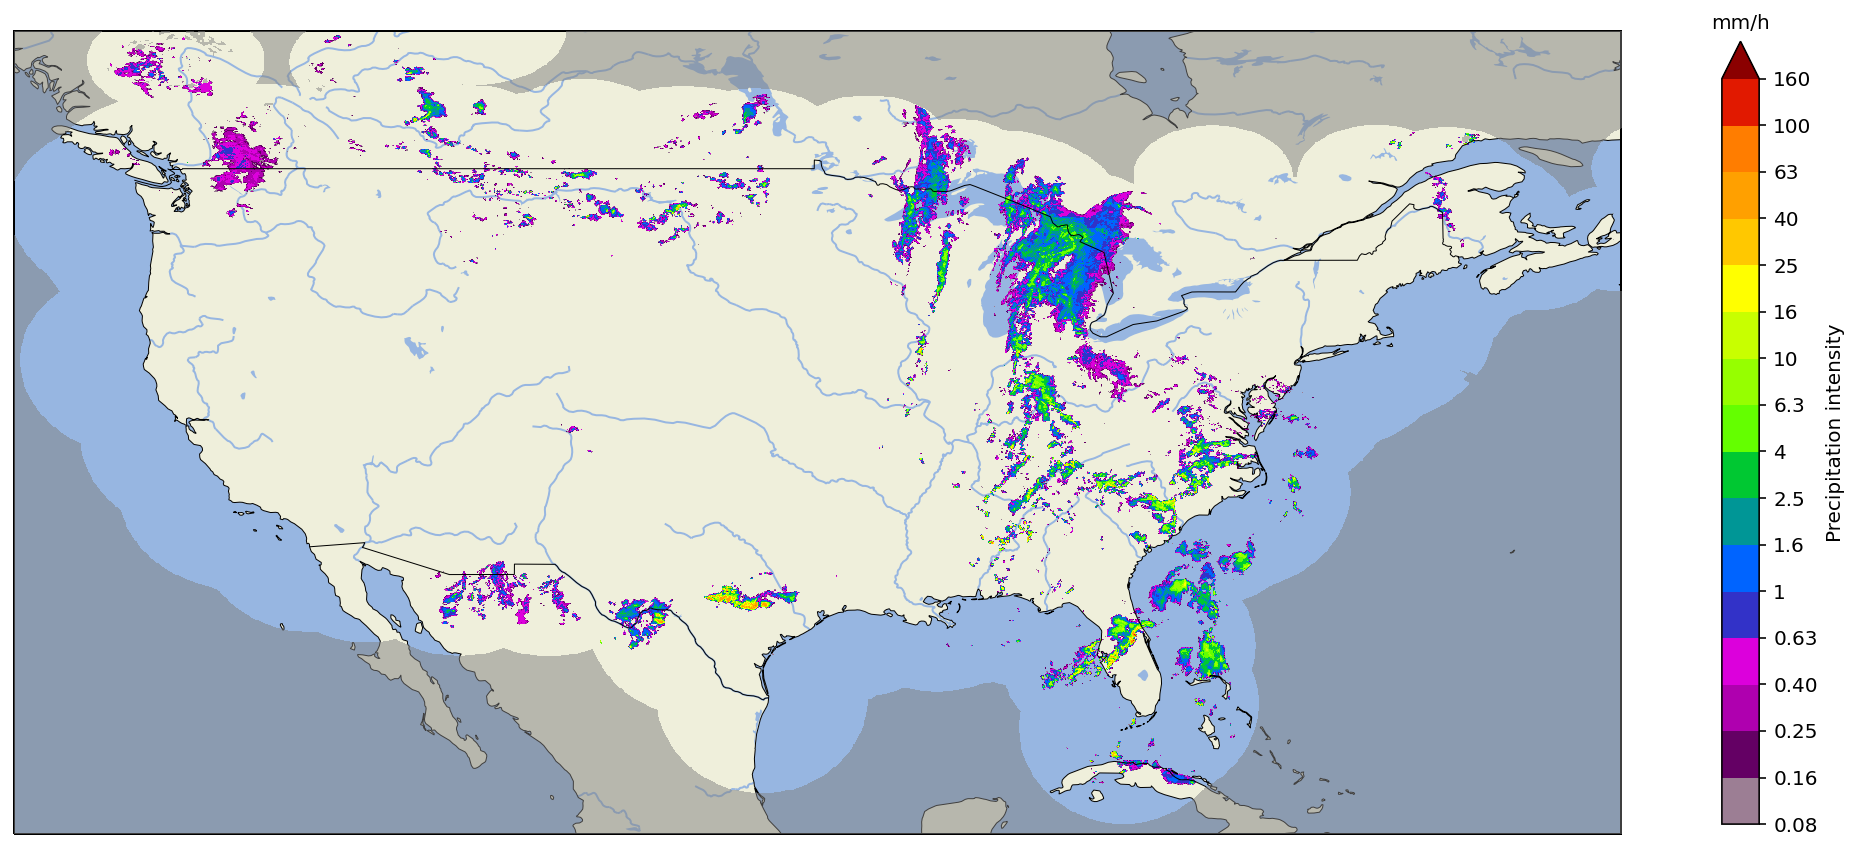

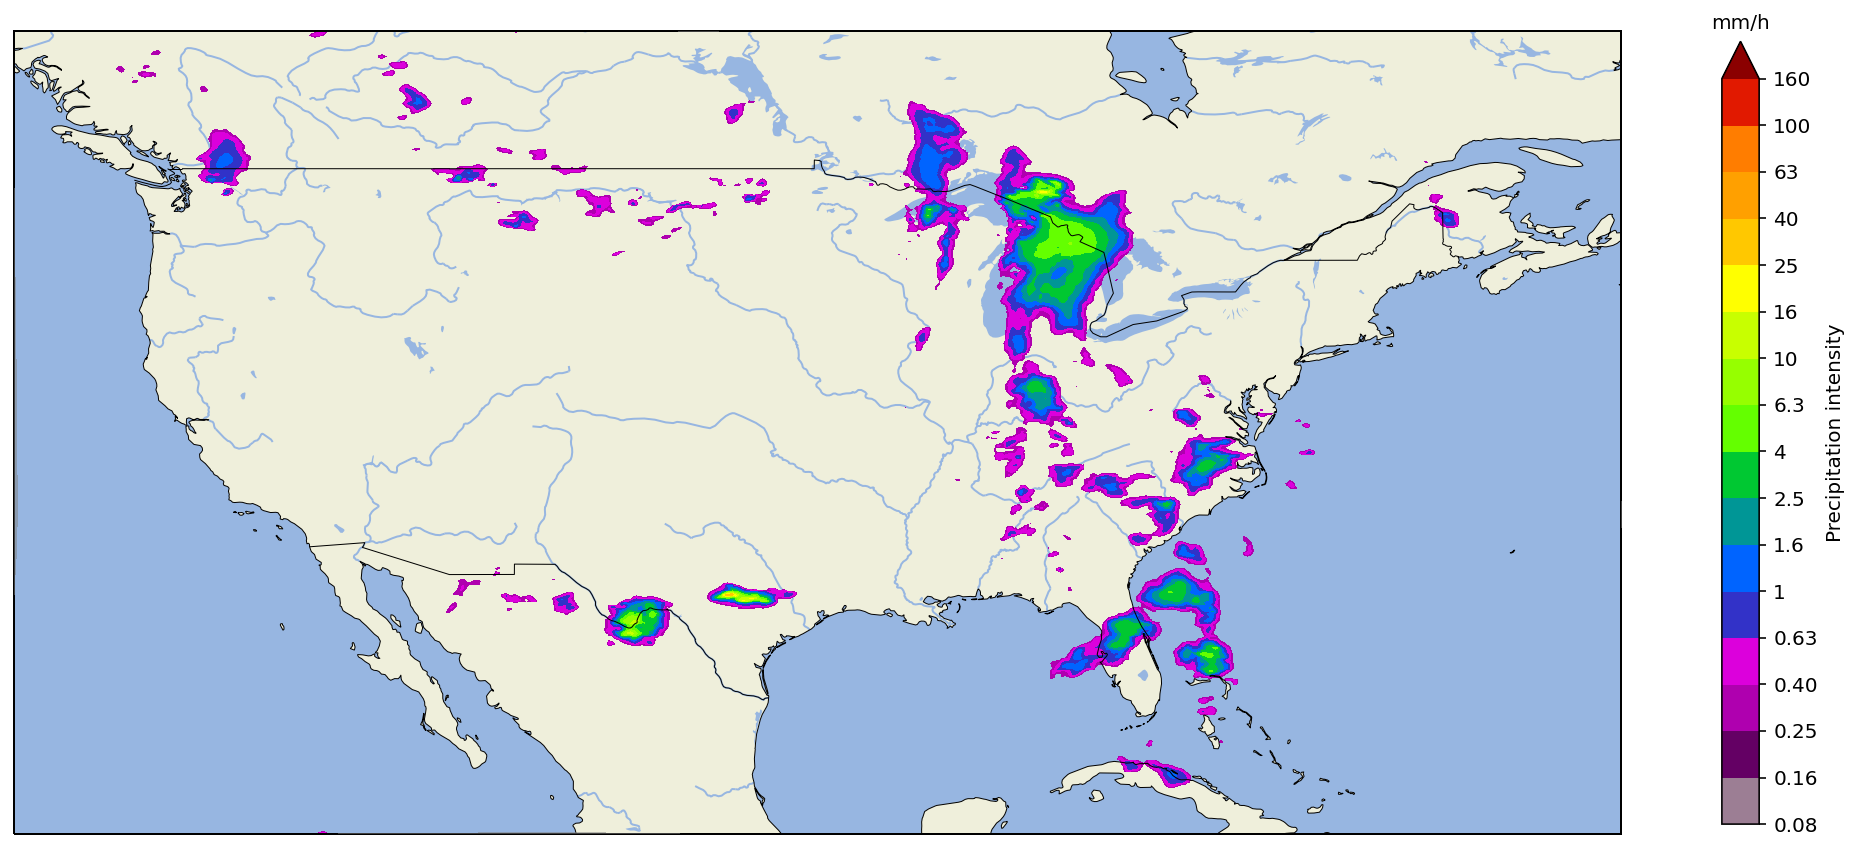

In [22]:
# Plot true precipitation at the end of the forecast period.
plt.figure(figsize=(18, 9))
plot_precip_field(observed_precip[-1], geodata=metadata, axis="off", map='cartopy')
plt.show()

# Plot precipitation at the end of the forecast period.
plt.figure(figsize=(18, 9))
plot_precip_field(precip_forecast_r[-1], geodata=metadata, axis="off", map='cartopy')
plt.show()

## Save motion field and nowcast

In [23]:
# motion_field
print('# Motion Field')
show_array_structure(motion_field)
print('\n\n')

# nowcast
print('# Nowcast')
show_array_structure(precip_forecast_r)

# Motion Field
shape = (2, 875, 1750)
shape[0] * shape[1] * shape[2] = 3062500
NAN amount = 0, part = 0.0
FINITE amount = 3062500, part = 1.0

unique = [-0.20445111 -0.20440098 -0.20439907 ...  0.41563349  0.41564025
  0.41567766]



# Nowcast
shape = (30, 875, 1750)
shape[0] * shape[1] * shape[2] = 45937500
NAN amount = 139781, part = 0.003
FINITE amount = 45797719, part = 0.997

unique = [0.00000000e+00 1.00003999e-01 1.00006246e-01 ... 8.47944282e+02
 9.34641696e+02 9.60825907e+02]


In [25]:
path = Path('./_result')
path_mf = path / 'motion_field' / 'lucaskanade'
path_nc = path / 'nowcast' / 'sprog'
path_mf.mkdir(parents=True, exist_ok=True)
path_nc.mkdir(parents=True, exist_ok=True)
# np.savez_compressed(path_mf/'001_simple.npz', array=motion_field)
np.savez_compressed(path_nc/'002_dBR.npz', array=precip_forecast_r)

## Evaluate the forecast quality

Many verification methods are already present in pysteps (see a complete list [here](https://pysteps.readthedocs.io/en/latest/pysteps_reference/verification.html)). We just have to import them. 

Here, we will evaluate our forecast using the Fractions Skill Score (FSS). 
This metric provides an intuitive assessment of the dependency of forecast skill on spatial scale and intensity. This makes the FSS an ideal skill score for high-resolution precipitation forecasts.

More precisely, the FSS is a neighborhood spatial verification method that directly compares the fractional coverage of events in windows surrounding the observations and forecasts.
The FSS varies from 0 (total mismatch) to 1 (perfect forecast).
For most situations, an FSS value of > 0.5 serves as a good indicator of a useful forecast ([Roberts and Lean, 2008](https://journals.ametsoc.org/doi/full/10.1175/2007MWR2123.1) and [Skok and Roberts, 2016](https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/qj.2849)). 

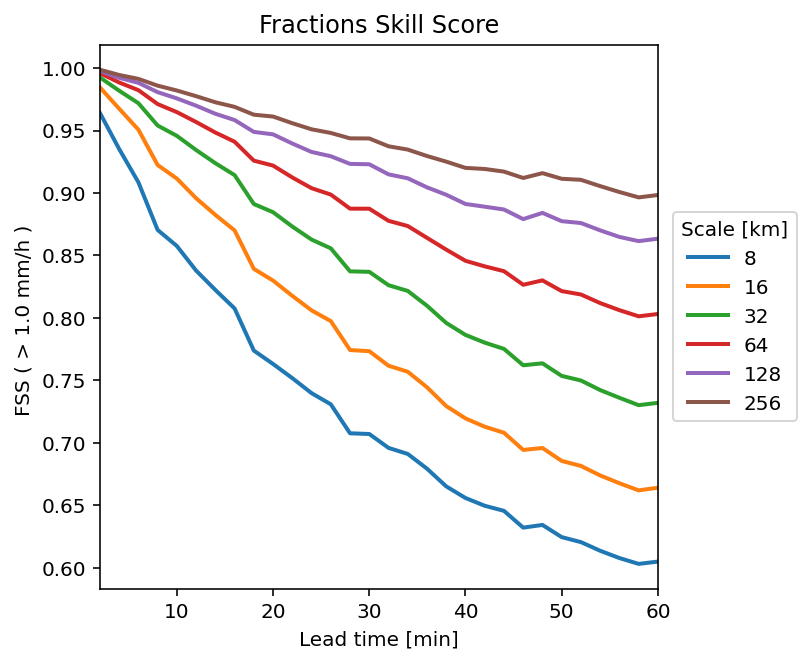

In [24]:
fss = verification.get_method("FSS")

# Compute fractions skill score (FSS) for all lead times for different scales using a 1 mm/h detection threshold.
scales = [
    2,
    4,
    8,
    16,
    32,
    64,
]  # In grid points.

scales_in_km = np.array(scales)*4

# Set the threshold
thr = 1.0  # in mm/h

score = []

# Calculate the FSS for every lead time and all predefined scales.
for i in range(n_leadtimes):
    score_ = []
    for scale in scales:
        score_.append(
            fss(precip_forecast_r[i, :, :], observed_precip[i, :, :], thr, scale)
        )
    score.append(score_)

# Now plot it
plt.figure(figsize=(5, 5))
x = np.arange(1, n_leadtimes+1) * timestep
plt.plot(x, score, lw=2.0)
plt.xlabel("Lead time [min]")
plt.ylabel("FSS ( > 1.0 mm/h ) ")
plt.title("Fractions Skill Score")
plt.legend(
    scales_in_km, 
    title="Scale [km]",
    loc="center left",
    bbox_to_anchor=(1.01, 0.5),
    bbox_transform=plt.gca().transAxes,
)
plt.autoscale(axis="x", tight=True)
plt.show()

As you can see, the FSS decreases with increasing lead time.
This is expected, as the forecasting quality slowly decreases when we forecast further ahead.
Upscaling the forecast, however, clearly leads to higher skill (up to longer ahead) compared to the forecast on the highest resolutions.